# Application of logistic regression to the classification problem

# Dataset description

The dataset contains information about the passengers of the Titanic, which sank on the night of April 15, 1912. A number of passengers were rescued due to many different factors, including their gender, age, which deck their cabin was on, social status, etc.

The dataset consists of various features that describe information about the passengers. Each row of the table is an individual passenger, with all the information about that passenger contained in its row.

Dataset description:
- **Survived** (target): whether passanger survived or not (0 = No, 1 = Yes);
- **Pclass**: ticket class (1 = 1st, 2 = 2nd, 3 = 3rd);
- **Sex**: gender (female или male)	
- **Age**: age in years
- **SibSp**: no. of siblings/spouses aboard the Titanic	
- **Parch**: no. of parents/children aboard the Titanic
- **Ticket**: ticket number	
- **Fare**: passenger fare
- **Cabin**: cabin number	
- **Embarked**: port of embarkation: (C = Cherbourg, Q = Queenstown, S = Southampton).

We need to solve the classification problem and learn to predict the target feature **Survived** (whether the passenger will survive) from the corresponding non-target features.


# Data preparation and exploratory analysis

In [52]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report

Find the number of missing values in the <code>age</code> column:

In [15]:
df = pd.read_csv('titanic_train.csv')
missing_count = df['age'].isnull().sum()
print(f"Number of missing values in 'age': {missing_count}")
df

Number of missing values in 'age': 199


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,335432,7.7333,NaN,Q,NaN
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,335677,7.7500,NaN,Q,"Co Clare, Ireland Washington, DC"
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,2688,7.2292,NaN,C,NaN
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,349252,7.8958,NaN,S,NaN
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,345778,9.5000,NaN,S,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,A. 2. 39186,8.0500,NaN,S,NaN
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,A/5. 10482,8.0500,NaN,S,"England Oglesby, IL"
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,12233,13.0000,NaN,S,"Vancouver, BC"
979,3,0,"Barton, Mr. David John",male,22.0,0,0,324669,8.0500,NaN,S,"England New York, NY"


Calculate the proportion of survivors.

In [19]:
survivors = df['survived'].isin([1]).sum()
non_survivors = df['survived'].isin([0]).sum()
proportion = survivors / (survivors + non_survivors)
print(f"Number of survivors: {survivors} \n number of non-survivors: {non_survivors} \n proportion: {proportion}")


Number of survivors: 375 
 number of non-survivors: 606 
 proportion: 0.382262996941896


Determine the proportion of missing values within each feature and get rid of those features where the proportion of missing values is greater than a third. Also delete the column <code>ticket</code> as this information is unlikely to be useful.

In [33]:
def remove_features_with_many_missing(df, threshold=0.33):
    """
    Determines the proportion of missing values in each feature and removes features
    with a proportion of missing values greater than a given threshold.
    Also removes a specified column.

    Args:
        df: The input DataFrame.
        threshold: The threshold for the proportion of missing values (default is 0.33).

    Returns:
        A new DataFrame with features having too many missing values removed,
        or None if input is not a DataFrame or if input is empty.  
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None

    # Calculate the proportion of missing values for each feature
    missing_counts = df.isnull().sum()
    total_counts = df.shape[0]
    missing_proportions = missing_counts / total_counts

    # Filter features with missing proportions above the threshold
    features_to_drop = missing_proportions[missing_proportions > threshold].index.tolist()

    # Add the 'ticket' column to the list of features to drop
    features_to_drop.append('ticket')

    # Drop the features and return the new DataFrame
    df_new = df.drop(columns=features_to_drop)
    return df_new
removed_df = remove_features_with_many_missing(df)
removed_df


,pclass,survived,name,sex,age,sibsp,parch,fare,embarked
0,3,1,"Smyth, Miss. Julia",female,NaN,0,0,7.7333,Q
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,0,0,7.7500,Q
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,0,0,7.2292,C
3,3,0,"Vovk, Mr. Janko",male,22.0,0,0,7.8958,S
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,0,0,9.5000,S
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,0,0,8.0500,S
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,0,0,8.0500,S
978,2,0,"Gillespie, Mr. William Henry",male,34.0,0,0,13.0000,S
979,3,0,"Barton, Mr. David John",male,22.0,0,0,8.0500,S


From the dataset description, you can see that the columns <code>sibsp</code> and <code>parch</code> are essentially responsible for family size. Replace these two columns with the <code>fam_size</code> column, whose values will be calculated as the sum of the corresponding values in the columns <code>sibsp</code> and <code>parch</code>.

In [34]:
def create_fam_size(df):
    """
    Replaces 'sibsp' and 'parch' columns with a 'fam_size' column that
    calculates the family size as the sum of 'sibsp' and 'parch'.

    Args:
        df: The input DataFrame with 'sibsp' and 'parch' columns.

    Returns:
       A new DataFrame with the new column and the old columns removed, 
       or None if the input is not a DataFrame or empty.
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None

    if 'sibsp' not in df.columns or 'parch' not in df.columns:
        print("Error: DataFrame must contain 'sibsp' and 'parch' columns.")
        return None

    # Create the 'fam_size' column
    df_new = df.copy()
    df_new['fam_size'] = df_new['sibsp'] + df_new['parch']

    # Remove original columns
    df_new = df_new.drop(columns=['sibsp', 'parch'])

    return df_new
fam_removed_df = create_fam_size(removed_df)
fam_removed_df["fam_size"].mean()

np.float64(0.8664627930682977)

The resulting dataset will be called **INITIAL** (the features discarded at this stage do not need to be returned at any of the subsequent stages of the task).

In [35]:
fam_removed_df

,pclass,survived,name,sex,age,fare,embarked,fam_size
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0
...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0


Based on available statistics, estimate the probability of survival if the passenger is a member of the particular category (this category is pecified in your individual assignment).

In [91]:
# sex = "female", pclass = "2"
filtered_df_survived = fam_removed_df[(fam_removed_df['sex'] == 'female') & (fam_removed_df['pclass'] == 2) & (fam_removed_df['survived'] == 1)]
female_p2_survivors = len(filtered_df_survived)
filtered_df_non_survived = fam_removed_df[(fam_removed_df['sex'] == 'female') & (fam_removed_df['pclass'] == 2) & (fam_removed_df['survived'] == 0)]
female_p2_non_survivors = len(filtered_df_non_survived)
proportion = female_p2_survivors/(female_p2_survivors+female_p2_non_survivors)
print(female_p2_survivors, proportion)

66 0.8461538461538461


Construct histograms of survivors and non-survivors by age.

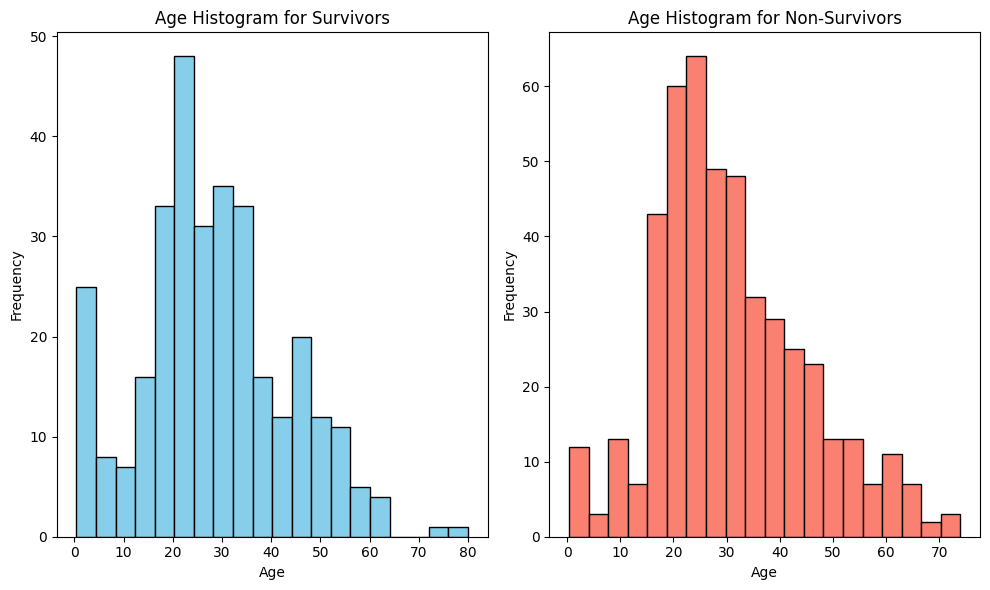

In [37]:
def plot_age_histograms(df):
    """
    Generates histograms of age for survivors and non-survivors.

    Args:
        df: The input DataFrame with 'age' and 'survived' columns.

    Returns:
       None
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None
    if 'age' not in df.columns or 'survived' not in df.columns:
      print("Error: Required column not available in the dataframe.")
      return None

    # Separate survivors and non-survivors
    survivors = df[df['survived'] == 1]
    non_survivors = df[df['survived'] == 0]

    # Create histograms
    plt.figure(figsize=(10, 6))  # Adjust figure size as needed

    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    plt.hist(survivors['age'].dropna(), bins=20, color='skyblue', edgecolor='black')
    plt.title('Age Histogram for Survivors')
    plt.xlabel('Age')
    plt.ylabel('Frequency')


    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    plt.hist(non_survivors['age'].dropna(), bins=20, color='salmon', edgecolor='black')
    plt.title('Age Histogram for Non-Survivors')
    plt.xlabel('Age')
    plt.ylabel('Frequency')

    plt.tight_layout() # Avoid overlapping titles
    plt.show()

plot_age_histograms(fam_removed_df)

# Model based on numerical features

## Removing rows with missing values

As a base model, it makes sense to build a model with minimal effort.

From the initial dataset, remove all categorical features as well as rows containing missing values.

Use <code>train_test_split()</code> to split the dataset into training and test samples <b>with the parameters specified in your individual assigment</b>. Use stratification by column <code>survived</code>.

Train <code>LogisticRegression()</code> model (<b>with the parameters specified in your individual assigment</b>) on training dataset, and evaluate the model on test dataset.

Compute <code>f1_score()</code> of the model on the test dataset (we recommend using <a href="https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html">the corresponding function</a> with default parameters).

In [44]:
def remove_categorical_and_missing(df):
  """
    Removes all categorical features and rows with missing values from a DataFrame.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with only numerical features and no rows with missing values,
        or None if the input is not correct.
  """

  if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None
  # Identify categorical columns
  categorical_cols = df.select_dtypes(include=['object']).columns.tolist()

  # Remove categorical columns
  df_no_cat = df.drop(columns=categorical_cols, errors='ignore')
  # Remove rows with any missing values
  df_cleaned = df_no_cat.dropna()
  return df_cleaned

base_df = remove_categorical_and_missing(fam_removed_df)
base_df

,pclass,survived,age,fare,fam_size
2,3,1,38.0,7.2292,0
3,3,0,22.0,7.8958,0
4,3,0,16.0,9.5000,0
5,3,1,29.0,7.7500,0
7,1,0,25.0,26.0000,0
...,...,...,...,...,...
975,2,0,19.0,10.5000,0
977,3,1,19.0,8.0500,0
978,2,0,34.0,13.0000,0
979,3,0,22.0,8.0500,0


In [46]:
X = base_df.drop(columns=['survived'])
y = base_df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

In [48]:
model = LogisticRegression(random_state=15, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
f1

np.float64(0.509090909090909)

## Filling missing values with the mean

The quality of the resulting model leaves much to be desired. It makes sense to try to fill the missing values. Remove categorical features from the initial dataset, and fill missing values with the mean value of the column. The following steps are similar: splitting, training, evaluation.

Compute <code>f1_score()</code> of the model on the test dataset.

In [50]:
def select_numerical_and_fill_missing(df):
  """
  Selects only the numerical features from a DataFrame and fills missing values
  with the mean value of each column.

  Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with only numerical features and missing values filled,
        or None if the input is not correct.
  """

  if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None

  # Select numerical columns
  numerical_cols = df.select_dtypes(include=np.number).columns.tolist()

  # Create a copy of the numerical data
  df_numerical = df[numerical_cols].copy()
  # Fill missing values with the mean for each numerical column
  df_filled = df_numerical.fillna(df_numerical.mean())

  return df_filled
mean_num_df = select_numerical_and_fill_missing(fam_removed_df)
mean_num_df

,pclass,survived,age,fare,fam_size
0,3,1,29.963448,7.7333,0
1,3,1,29.963448,7.7500,0
2,3,1,38.000000,7.2292,0
3,3,0,22.000000,7.8958,0
4,3,0,16.000000,9.5000,0
...,...,...,...,...,...
976,3,1,29.963448,8.0500,0
977,3,1,19.000000,8.0500,0
978,2,0,34.000000,13.0000,0
979,3,0,22.000000,8.0500,0


In [51]:
X = mean_num_df.drop(columns=['survived'])
y = mean_num_df['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

model = LogisticRegression(random_state=15, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
f1

np.float64(0.48214285714285715)

## Filling missing values based on honorifics

Obviously, filling missing values in the <code>age</code> column with mean is not the smartest idea. Perhaps you should perform this procedure somehow more intelligently, for example, with an eye on appealing to the person. 

You can notice that the initial dataset in the column contains information about the social status of the passenger, namely, there are appeals <code>Mr., Mrs., Dr.</code>, etc. Based on this information, we can try to make an assumption about the passenger's age.

Put the column <code>name</code> back into consideration. Create a separate <code>honorific</code> column and put the appeal values there.

Calculate the number of unique appeals.

In [54]:
def extract_honorifics(df):
  """
  Selects numeric features and the 'name' column, extracts honorifics
  from the 'name' column, and creates a new 'honorific' column.

  Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with numeric features, 'name' column, and 'honorific' column,
         or None if the input is not correct.
  """
  if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None

  if 'name' not in df.columns:
    print("Error: DataFrame must contain 'name' columns.")
    return None

  # Select numerical columns
  numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
  # Select the name column
  selected_cols = numerical_cols + ['name']

  # create a new DataFrame with the selected columns
  df_new = df[selected_cols].copy()


  # Extract honorifics
  def extract_honorific(name):
      match = re.search(r'(\w+)\.', name)
      if match:
          return match.group(1)
      return None

  df_new['honorific'] = df_new['name'].apply(extract_honorific)

  return df_new
honorifics_df = extract_honorifics(fam_removed_df)
honorifics_df

,pclass,survived,age,fare,fam_size,name,honorific
0,3,1,NaN,7.7333,0,"Smyth, Miss. Julia",Miss
1,3,1,NaN,7.7500,0,"Glynn, Miss. Mary Agatha",Miss
2,3,1,38.0,7.2292,0,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",Mrs
3,3,0,22.0,7.8958,0,"Vovk, Mr. Janko",Mr
4,3,0,16.0,9.5000,0,"de Pelsmaeker, Mr. Alfons",Mr
...,...,...,...,...,...,...,...
976,3,1,NaN,8.0500,0,"Howard, Miss. May Elizabeth",Miss
977,3,1,19.0,8.0500,0,"Dorking, Mr. Edward Arthur",Mr
978,2,0,34.0,13.0000,0,"Gillespie, Mr. William Henry",Mr
979,3,0,22.0,8.0500,0,"Barton, Mr. David John",Mr


In [60]:
unique_count = honorifics_df['honorific'].nunique()
unique_count

14

In [59]:

unique_honorifics = honorifics_df['honorific'].unique().tolist()
unique_honorifics

['Miss',
 'Mrs',
 'Mr',
 'Master',
 'Mlle',
 'Rev',
 'Ms',
 'Col',
 'Dona',
 'Dr',
 'Countess',
 'Major',
 'Don',
 'Capt']

Most likely, it makes sense to reduce the number of appeals, adding small groups to the more numerous ones, as there seems to be no fundamental difference between, for example, <code>Don</code> and <code>Mr</code>. Note that <code>Master</code> is a former appeal to a child, we will work with this appeal separately.




Make the following substitutions:

<code>Mr</code> $\leftarrow$ <code>['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt']</code>

<code>Mrs</code> $\leftarrow$ <code> ['Dona', 'Countess']</code>

<code>Miss</code> $\leftarrow$ <code> ['Mlle', 'Ms']</code>

In [63]:
substitutions = {
        'Mr': ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'],
        'Mrs': ['Dona', 'Countess'],
        'Miss':['Mlle', 'Ms']
    }
for original, subs in substitutions.items():
        honorifics_df['honorific'] = honorifics_df['honorific'].replace(subs, original)
unique_honorifics = honorifics_df['honorific'].unique().tolist()
unique_honorifics

['Miss', 'Mrs', 'Mr', 'Master']

Calculate the proportion of rows with the <code>Master</code> value relative to the number of all males.

In [67]:
filtered_df_male = fam_removed_df[(fam_removed_df['sex'] == 'male')]
male_count = len(filtered_df_male)
filtered_df_master = honorifics_df[(honorifics_df['honorific'] == 'Master')]
master_count = len(filtered_df_master)
master_proportion = master_count/male_count
master_proportion

0.07232704402515723

Calculate the average age of the category specified in your individual assigment.

In [69]:
filtered_df_Mrs = honorifics_df[honorifics_df['honorific'] == "Mrs"]
average_age_Mrs = filtered_df_Mrs['age'].mean()
average_age_Mrs

np.float64(36.98425196850393)

Fill the missing values in the column <code>age</code> with the mean corresponding to the mean of the <code>honorific</code> category.

Get rid of non-numeric features. Next steps are similar: splitting, training, evaluation.

Compute <code>f1_score()</code> of the model on the test dataset.

In [70]:
def fill_missing_age_by_honorific(df):
    """
    Fills missing 'age' values based on the mean of their honorific category,
    and removes non-numeric features.

    Args:
        df: The input DataFrame with 'honorific' and 'age' columns.

    Returns:
        A new DataFrame with missing ages filled, non-numeric features removed or None
        if there is an error.
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None

    if 'honorific' not in df.columns or 'age' not in df.columns:
        print("Error: DataFrame must contain 'honorific' and 'age' columns.")
        return None

    df_new = df.copy()

    # Calculate mean age per honorific
    mean_ages = df_new.groupby('honorific')['age'].mean()

    # Fill missing age values based on honorific mean
    df_new['age'] = df_new.apply(lambda row: mean_ages[row['honorific']] if pd.isna(row['age']) else row['age'], axis=1)

    # Remove non-numeric features
    numerical_cols = df_new.select_dtypes(include=np.number).columns.tolist()
    df_cleaned = df_new[numerical_cols]
    return df_cleaned
honorifics_df_mean = fill_missing_age_by_honorific(honorifics_df)
honorifics_df_mean

,pclass,survived,age,fare,fam_size
0,3,1,22.005765,7.7333,0
1,3,1,22.005765,7.7500,0
2,3,1,38.000000,7.2292,0
3,3,0,22.000000,7.8958,0
4,3,0,16.000000,9.5000,0
...,...,...,...,...,...
976,3,1,22.005765,8.0500,0
977,3,1,19.000000,8.0500,0
978,2,0,34.000000,13.0000,0
979,3,0,22.000000,8.0500,0


In [72]:
X = honorifics_df_mean.drop(columns=['survived'])
y = honorifics_df_mean['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

model = LogisticRegression(random_state=15, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
f1

np.float64(0.4642857142857143)

# Model that uses categorical features

In the original dataset, fill the missing values in the column <code>age</code> with values based on the appeals (as in the previous step). 

After that, drop the features <code>name</code> and <code>honorific</code>. They have fulfilled their function.

Perform <code>one-hot</code> encoding of the non-numeric features, for example, with <code>pd.get_dummies(drop_first=True)</code>. Then follow the familiar pattern: split, train, evaluate.

Compute <code>f1_score()</code> of the model on the test dataset.

In [79]:
def add_honorifics(df):
  # Extract honorifics
  def extract_honorific(name):
      match = re.search(r'(\w+)\.', name)
      if match:
          return match.group(1)
      return None
  df_new = df.copy()
  df_new['honorific'] = df_new['name'].apply(extract_honorific)
  return df_new
end_df = add_honorifics(fam_removed_df)

substitutions = {
        'Mr': ['Rev', 'Col', 'Dr', 'Major', 'Don', 'Capt'],
        'Mrs': ['Dona', 'Countess'],
        'Miss':['Mlle', 'Ms']
    }
for original, subs in substitutions.items():
        end_df['honorific'] = end_df['honorific'].replace(subs, original)
unique_honorifics = end_df['honorific'].unique().tolist()
unique_honorifics

['Miss', 'Mrs', 'Mr', 'Master']

In [80]:
end_df

,pclass,survived,name,sex,age,fare,embarked,fam_size,honorific
0,3,1,"Smyth, Miss. Julia",female,NaN,7.7333,Q,0,Miss
1,3,1,"Glynn, Miss. Mary Agatha",female,NaN,7.7500,Q,0,Miss
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.0,7.2292,C,0,Mrs
3,3,0,"Vovk, Mr. Janko",male,22.0,7.8958,S,0,Mr
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.0,9.5000,S,0,Mr
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,NaN,8.0500,S,0,Miss
977,3,1,"Dorking, Mr. Edward Arthur",male,19.0,8.0500,S,0,Mr
978,2,0,"Gillespie, Mr. William Henry",male,34.0,13.0000,S,0,Mr
979,3,0,"Barton, Mr. David John",male,22.0,8.0500,S,0,Mr


In [82]:
def fill_missing_age_by_honorific_only(df):
    """
    Fills missing 'age' values based on the mean of their honorific category,
    and removes non-numeric features.

    Args:
        df: The input DataFrame with 'honorific' and 'age' columns.

    Returns:
        A new DataFrame with missing ages filled, non-numeric features removed or None
        if there is an error.
    """
    if not isinstance(df, pd.DataFrame) or df.empty:
        print("Error: Input must be a non-empty DataFrame.")
        return None

    if 'honorific' not in df.columns or 'age' not in df.columns:
        print("Error: DataFrame must contain 'honorific' and 'age' columns.")
        return None

    df_new = df.copy()

    # Calculate mean age per honorific
    mean_ages = df_new.groupby('honorific')['age'].mean()

    # Fill missing age values based on honorific mean
    df_new['age'] = df_new.apply(lambda row: mean_ages[row['honorific']] if pd.isna(row['age']) else row['age'], axis=1)
    return df_new
end_df_mean = fill_missing_age_by_honorific_only(end_df)
end_df_mean

,pclass,survived,name,sex,age,fare,embarked,fam_size,honorific
0,3,1,"Smyth, Miss. Julia",female,22.005765,7.7333,Q,0,Miss
1,3,1,"Glynn, Miss. Mary Agatha",female,22.005765,7.7500,Q,0,Miss
2,3,1,"Whabee, Mrs. George Joseph (Shawneene Abi-Saab)",female,38.000000,7.2292,C,0,Mrs
3,3,0,"Vovk, Mr. Janko",male,22.000000,7.8958,S,0,Mr
4,3,0,"de Pelsmaeker, Mr. Alfons",male,16.000000,9.5000,S,0,Mr
...,...,...,...,...,...,...,...,...,...
976,3,1,"Howard, Miss. May Elizabeth",female,22.005765,8.0500,S,0,Miss
977,3,1,"Dorking, Mr. Edward Arthur",male,19.000000,8.0500,S,0,Mr
978,2,0,"Gillespie, Mr. William Henry",male,34.000000,13.0000,S,0,Mr
979,3,0,"Barton, Mr. David John",male,22.000000,8.0500,S,0,Mr


In [86]:
end_df_drop = end_df_mean.drop(columns=["name", "honorific"])
end_df_drop

,pclass,survived,sex,age,fare,embarked,fam_size
0,3,1,female,22.005765,7.7333,Q,0
1,3,1,female,22.005765,7.7500,Q,0
2,3,1,female,38.000000,7.2292,C,0
3,3,0,male,22.000000,7.8958,S,0
4,3,0,male,16.000000,9.5000,S,0
...,...,...,...,...,...,...,...
976,3,1,female,22.005765,8.0500,S,0
977,3,1,male,19.000000,8.0500,S,0
978,2,0,male,34.000000,13.0000,S,0
979,3,0,male,22.000000,8.0500,S,0


In [88]:
def one_hot_encode_non_numeric(df):
    """
    Performs one-hot encoding on non-numeric features of a DataFrame.

    Args:
        df: The input DataFrame.

    Returns:
        A new DataFrame with one-hot encoded non-numeric features, or None if input is not correct.
    """

    if not isinstance(df, pd.DataFrame) or df.empty:
      print("Error: Input must be a non-empty DataFrame.")
      return None

    # Identify non-numeric (categorical) columns
    non_numeric_cols = df.select_dtypes(exclude=np.number).columns.tolist()

    if not non_numeric_cols:
        print("There are no non-numeric columns to perform one-hot encoding on.")
        return df.copy()

    # Perform one-hot encoding
    df_encoded = pd.get_dummies(df, columns=non_numeric_cols, drop_first=True)

    return df_encoded
end_df_encoded = one_hot_encode_non_numeric(end_df_drop)
end_df_encoded
#потерян C в embarked

,pclass,survived,age,fare,fam_size,sex_male,embarked_Q,embarked_S
0,3,1,22.005765,7.7333,0,False,True,False
1,3,1,22.005765,7.7500,0,False,True,False
2,3,1,38.000000,7.2292,0,False,False,False
3,3,0,22.000000,7.8958,0,True,False,True
4,3,0,16.000000,9.5000,0,True,False,True
...,...,...,...,...,...,...,...,...
976,3,1,22.005765,8.0500,0,False,False,True
977,3,1,19.000000,8.0500,0,True,False,True
978,2,0,34.000000,13.0000,0,True,False,True
979,3,0,22.000000,8.0500,0,True,False,True


In [90]:
X = end_df_encoded.drop(columns=['survived'])
y = end_df_encoded['survived']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=15)

model = LogisticRegression(random_state=15, max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

f1 = f1_score(y_test, y_pred)
f1

np.float64(0.6524822695035462)